# Quickstart Example with Synthetic RTB Simulation and Dataset (Discrete)
This notebook provides an example of conducting **Off-policy Evaluation (OPE) and Offline Reinforcement Learning (Offline RL) on a synthetic Real-Time Bidding (RTB) dataset**.

This example consists of the following 5 steps: \
0. (Setup Synthetic RTB Simulation Environment and Online RL)
1. Synthetic Data Generation
2. Offline Reinforcement Learning
3. Off-Policy Evaluation and Evaluation of Offline RL methods
4. Evaluation of OPE methods

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of online/offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# import SCOPE-RL modules
import scope_rl
from rtbgym import RTBEnv, CustomizedRTBEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from scope_rl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [4]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
# version
print(scope_rl.__version__)

0.0.0


In [6]:
# set random state
random_state = 12345

In [7]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 0. (Setup Synthetic RTB Simulation Environment and Online RL)
To begin with, we briefly describe how the RTB environment works for the preparation.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (number of clicks or conversions) within an episode under given budget constraints.  
We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we can adjust the bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes a predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe some feedback from the environment at each timestep, which includes the following.
  - timestep
  - remaining budget
  - impression level features (budget consumption rate, cost per mille of impressions, auction winning rate, reward) at the previous timestep
  - adjust rate (RL agent's decision making) at the previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

For more about the environmental configuration , please refer to [examples/quickstart/rtb/rtb_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_customize_env.ipynb).

Let's see how it works!

In [8]:
# setup environment
env = RTBEnv(random_state=random_state)

In [9]:
# define a random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # minimum value that policy can take
            maximum=10,  # maximum value that policy can take
        )
    ),
    name="random",
)

In [10]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [11]:
# state contains the following feedback from the environment
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


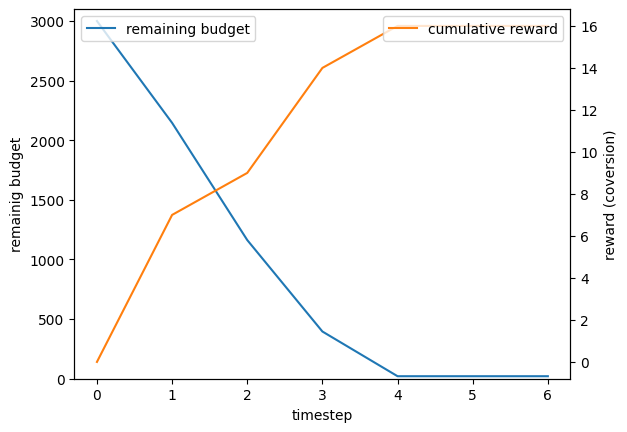

In [12]:
# let's visualize the transition of the remaining budget and cumulative reward
# our goal is to obtain a policy (or an agent) that maximizes the cumulative reward under budget constraints using RL.  
obs, info = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action = agent.predict_online(obs)
    obs, reward, done, truncated, info = env.step(action)
    remaining_budget.append(obs[1])
    cumulative_reward.append(cumulative_reward[-1] + reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(remaining_budget[:-1], label='remaining budget')
ax2 = ax1.twinx()
ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax1.set_ylim(0, env.initial_budget + 100)
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

We see that the random policy run out the budget quickly.  
Our goal is to derive a policy that controls the adjust rate (i.e., action) to maximize the reward within the given budget constraints.

For more about the environmental configurations and customization, please refer to [examples/quickstart/rtb/rtb_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_customize_env.ipynb).

#### Online RL and comparison of the policies
We now learn an online RL policy and compare it to the random policy, using on-policy policy estimation.

In [13]:
# standardized environment for discrete action
env = gym.make("RTBEnv-discrete-v0")
print(env.action_meaning)

[ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]


In [14]:
# for api compatibility to d3rlpy
from scope_rl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

In [15]:
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.3,
    duration=1000,
)

In [ ]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env_,
    buffer,
    explorer=explorer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [20]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [16]:
# reload model
ddqn.build_with_env(env_)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

Text(0, 0.5, 'episode reward')

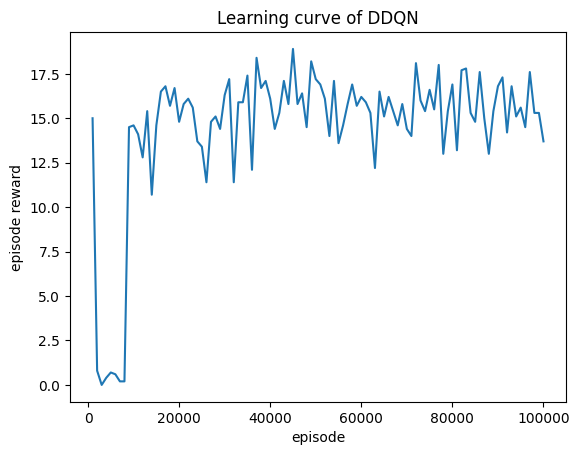

In [17]:
# we see that training RL policy can be risky online
log_path = sorted(glob("d3rlpy_logs/DoubleDQN_online_*/evaluation.csv"))[-1]
df = pd.read_csv(
    log_path, 
    usecols=[1,2],
    names=["train_episode", "episodic_rewards"]
)
plt.plot(df["train_episode"], df["episodic_rewards"])
plt.title("Learning curve of DDQN")
plt.xlabel("episode")
plt.ylabel("episode reward")

In [18]:
random = DiscreteRandomPolicy()
random.build_with_env(env_)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

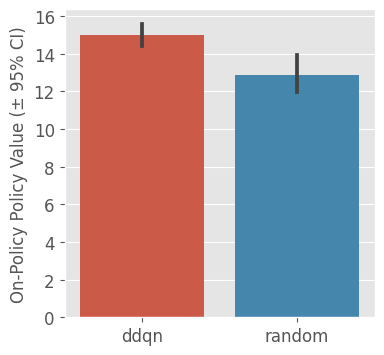

In [19]:
# compare the policy performance online
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, random],
    policy_names=["ddqn", "random"],
    n_trajectories=100,
    random_state=random_state,
)

In [20]:
# on-policy policy value by ddqn policy
# largely outperforms the random policy (about 20%)
ddqn_performance = calc_on_policy_policy_value(env, ddqn, n_trajectories=100, random_state=random_state)
random_performance = calc_on_policy_policy_value(env, random, n_trajectories=100, random_state=random_state)
print("relative improvement:", (ddqn_performance - random_performance) / random_performance)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

relative improvement: 0.20144462279293737


Note that, we provide the following functions for online evaluation of the policy performance under `scope_rl.ope.online`.

(Statistics)

* `calc_on_policy_policy_value`
* `calc_on_policy_policy_value_interval`
* `calc_on_policy_variance`
* `calc_on_policy_conditional_value_at_risk`
* `calc_on_policy_policy_interquartile_range`
* `calc_on_policy_cumulative_distribution_function`

(Visualization)
* `visualize_on_policy_policy_value`
* `visualize_on_policy_policy_value_with_variance`
* `visualize_on_policy_cumulative_distribution_function`
* `visualize_on_policy_conditional_value_at_risk`
* `visualize_on_policy_interquartile_range`

## 1. Synthetic Dataset Generation
In the previous section, we see how we can interact with the environment *online* using synthetic simulator.  
Though simulation is a good starting point for training an agent, eventually we want to deploy our agent (or policy) in the real world environment.  
However, online interaction may have potential risk of failure in the real-world.
Therefore, we introduce an alternative learning protocol, Offline RL, which aims at training a new policy using only offline logged dataset collected by a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

We prepare an easy-to-use synthetic dataset generator: `SyntheticDataset` class in the dataset module.  
By regarding the simulation environment as a hypothetical real-environment, we show how to conduct Offline RL using logged dataset in real-world application.  
For detailed description of how to use a real-world dataset, please see #TODO (will be implemented).

`SyntheticDataset` has the following arguments:
- `env`: RTB environment for RL defined in the previous section.
- `action_meaning`: Dictionary which maps discrete action index into specific actions.
- `state_keys`: Name of the state variable at each dimension.
- `max_episode_steps`: Maximum number of timesteps in an episode.
- `info_keys`: Dictionary containing of key and the type of info components.

In [21]:
# import necessary module from SCOPE-RL
from scope_rl.policy import DiscreteEpsilonGreedyHead

In [22]:
behavior_policy = DiscreteEpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [23]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    action_meaning=env.action_meaning,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)

In [29]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state + 1,
)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [25]:
train_logged_dataset

{'size': 70000,
 'n_trajectories': 10000,
 'step_per_trajectory': 7,
 'action_type': 'discrete',
 'n_actions': 10,
 'action_dim': None,
 'action_meaning': array([ 0.1       ,  0.16681005,  0.27825594,  0.46415888,  0.77426368,
         1.29154967,  2.15443469,  3.59381366,  5.9948425 , 10.        ]),
 'action_keys': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 8.26436129e-01, ...,
         9.56309981e-01, 1.00000000e+00, 1.39235629e+00],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         1.00000000e+00, 6.00000000e+00, 5.99484250e+00],
        [2.00000000e+00, 1.91000000e+03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.66810054e-01],
        ...,
        [4.00000000e+00, 1.39000000e+02, 8.87358185e-01, ...,
         1.00000000e+00, 4.00000000e+00, 5.99484250e+0

In [31]:
with open("logs/train_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddqn.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [24]:
with open("logs/train_dataset_discrete_ddqn.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddqn.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

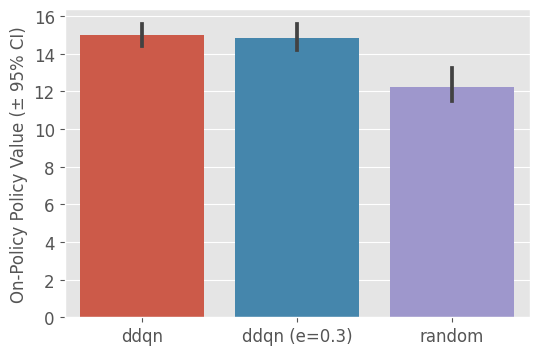

In [26]:
# compare the policy performance online
# almost the same performance as greedy ddqn
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, behavior_policy, random],
    policy_names=["ddqn", "ddqn (e=0.3)", "random"],
    n_trajectories=100,
    random_state=random_state,
)

In [27]:
# let's see some statistics of the dataset
df = pd.DataFrame()
df['adjust rate'] = train_logged_dataset['state'][:, 6]
df['average bid price'] = train_logged_dataset['info']['average_bid_price']
df['impression'] = train_logged_dataset['info']['impression']
df['click'] = train_logged_dataset['info']['click']
df['conversion'] = train_logged_dataset['info']['conversion']
df['winning rate'] = train_logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,3.653301,191.349435,88.550857,8.643286,2.064729,0.506857,0.062369,0.132919
std,2.889315,146.589024,90.176659,9.547978,2.950696,0.431365,0.072288,0.185133
min,0.000005,4.051887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.774264,38.014947,3.000000,0.000000,0.000000,0.033019,0.000000,0.000000
50%,3.593814,185.017996,41.000000,3.000000,0.000000,0.471115,0.070175,0.000000
75%,5.994843,307.757925,188.000000,18.000000,3.000000,1.000000,0.104265,0.230769
max,10.399672,546.900000,290.000000,42.000000,20.000000,1.000000,0.999995,0.999998


For more about the data collection and visualization, please refer to [examples/quickstart/rtb/rtb_synthetic_data_collection.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_data_collection.ipynb).

## 2. Offline Reinforcement Learning
In this section, we learn a new policy in an offline manner, without interacting with the environment.  
We use [d3rlpy](https://github.com/takuseno/d3rlpy)'s implementation of algorithms.

In [28]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQL
from d3rlpy.ope import DiscreteFQE
from d3rlpy.metrics.scorer import evaluate_on_environment

In [29]:
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
    episode_terminals=train_logged_dataset["done"],
    discrete_action=True,
)
train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

In [30]:
# Use Conservative Q-Learning policy
cql = DiscreteCQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

In [ ]:
cql.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={
        'environment': evaluate_on_environment(env_),
        # to record training process w/ ground truth policy value, which is unseen to the agent
    },
)

In [33]:
# save model
cql.save_model("d3rlpy_logs/cql_discrete.pt")

In [31]:
# reload model
cql.build_with_env(env_)
cql.load_model("d3rlpy_logs/cql_discrete.pt")

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

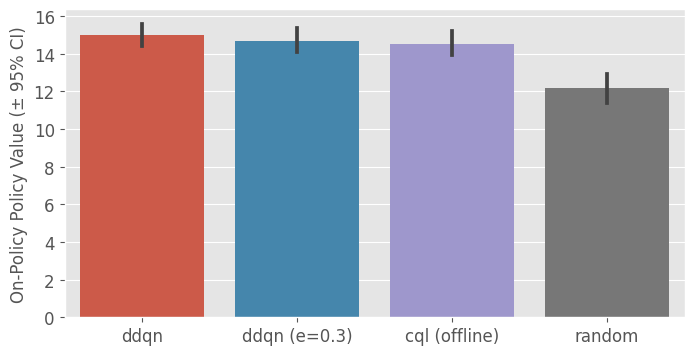

In [32]:
# compare the policy performance online
# not better than online policy, but achieves almost the same performance
# meaning that we can learn a reasonable policy without interacting with the environment!
visualize_on_policy_policy_value(
    env=env,
    policies=[ddqn, behavior_policy, cql, random],
    policy_names=["ddqn", "ddqn (e=0.3)", "cql (offline)", "random"],
    n_trajectories=100,
    random_state=random_state,
)

## 3. Off-Policy Evaluation and Evaluation of Offline RL methods
In the previous section, we verified the performance of a learned policy via online interaction (aka A/B tests).  
However, it could be risky because the policy may perform poorly in an online environment.  
To tackle this issue, we aim at evaluating the performance of a policy offline, to gain some prior knowledge on how agent works in the environment.

#### Estimation Target

The goal to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [33]:
# import ope modules from SCOPE-RL
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as OPE
from scope_rl.ope import DiscreteDirectMethod as DM
from scope_rl.ope import DiscreteTrajectoryWiseImportanceSampling as TIS
from scope_rl.ope import DiscretePerDecisionImportanceSampling as PDIS
from scope_rl.ope import DiscreteDoublyRobust as DR
from scope_rl.ope import DiscreteSelfNormalizedTIS as SNTIS
from scope_rl.ope import DiscreteSelfNormalizedPDIS as SNPDIS
from scope_rl.ope import DiscreteSelfNormalizedDR as SNDR

In [34]:
# define evaluation policies
cql_ = DiscreteEpsilonGreedyHead(base_policy=cql, n_actions=env.action_space.n, name="cql", epsilon=0.0, random_state=random_state)
ddqn_ = DiscreteEpsilonGreedyHead(base_policy=ddqn, n_actions=env.action_space.n, name="ddqn", epsilon=0.0, random_state=random_state)
random_ = DiscreteEpsilonGreedyHead(base_policy=random, n_actions=env.action_space.n, name="random", epsilon=1.0, random_state=random_state)
evaluation_policies = [cql_, ddqn_, random_]

In [35]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
)

In [ ]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [37]:
with open("logs/ope_input_dict_discrete.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [38]:
with open("logs/ope_input_dict_discrete.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [39]:
ope = OPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [40]:
# performance estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)

In [41]:
# estimated policy performance
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy     14.540000               1.000000
 dm             1.327861               0.091325
 tis            8.010232               0.550910
 pdis          13.380266               0.920238
 dr            13.689454               0.941503
 sntis         13.810127               0.949802
 snpdis        13.850935               0.952609
 sndr          13.650742               0.938841,
 'ddqn':            policy_value  relative_policy_value
 on_policy     14.970000               1.000000
 dm             2.639734               0.176335
 tis           15.345694               1.025096
 pdis          14.919924               0.996655
 dr            14.867006               0.993120
 sntis         14.845009               0.991651
 snpdis        14.863871               0.992911
 sndr          14.845818               0.991705,
 'random':            policy_value  relative_policy_value
 on_policy     12.570000               1.000000
 dm          

In [42]:
# estimated confidence intervals of the policy performance
policy_value_interval_df_dict

{'cql':                 mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy  14.456400         13.690000         15.145250
 dm          1.327601          1.319282          1.335902
 tis         7.745476          0.000000         23.178277
 pdis       13.504911         11.256578         16.110413
 dr         13.821838         11.637073         16.408637
 sntis      13.353671          0.000000         39.960759
 snpdis     13.989664         11.434440         16.981662
 sndr       13.807819         11.196468         17.041346,
 'ddqn':                 mean  95.0% CI (lower)  95.0% CI (upper)
 on_policy  14.894800         14.029000         15.617750
 dm          2.639579          2.635767          2.642611
 tis        15.335285         14.520387         16.065502
 pdis       14.917600         14.697135         15.199414
 dr         14.865720         14.669242         15.103088
 sntis      14.834939         14.046629         15.541331
 snpdis     14.861596         14.643359         15.14263

## 4. Evaluation of OPE methods
Now, we evaluate how well the ope estimators estimated the policy value.

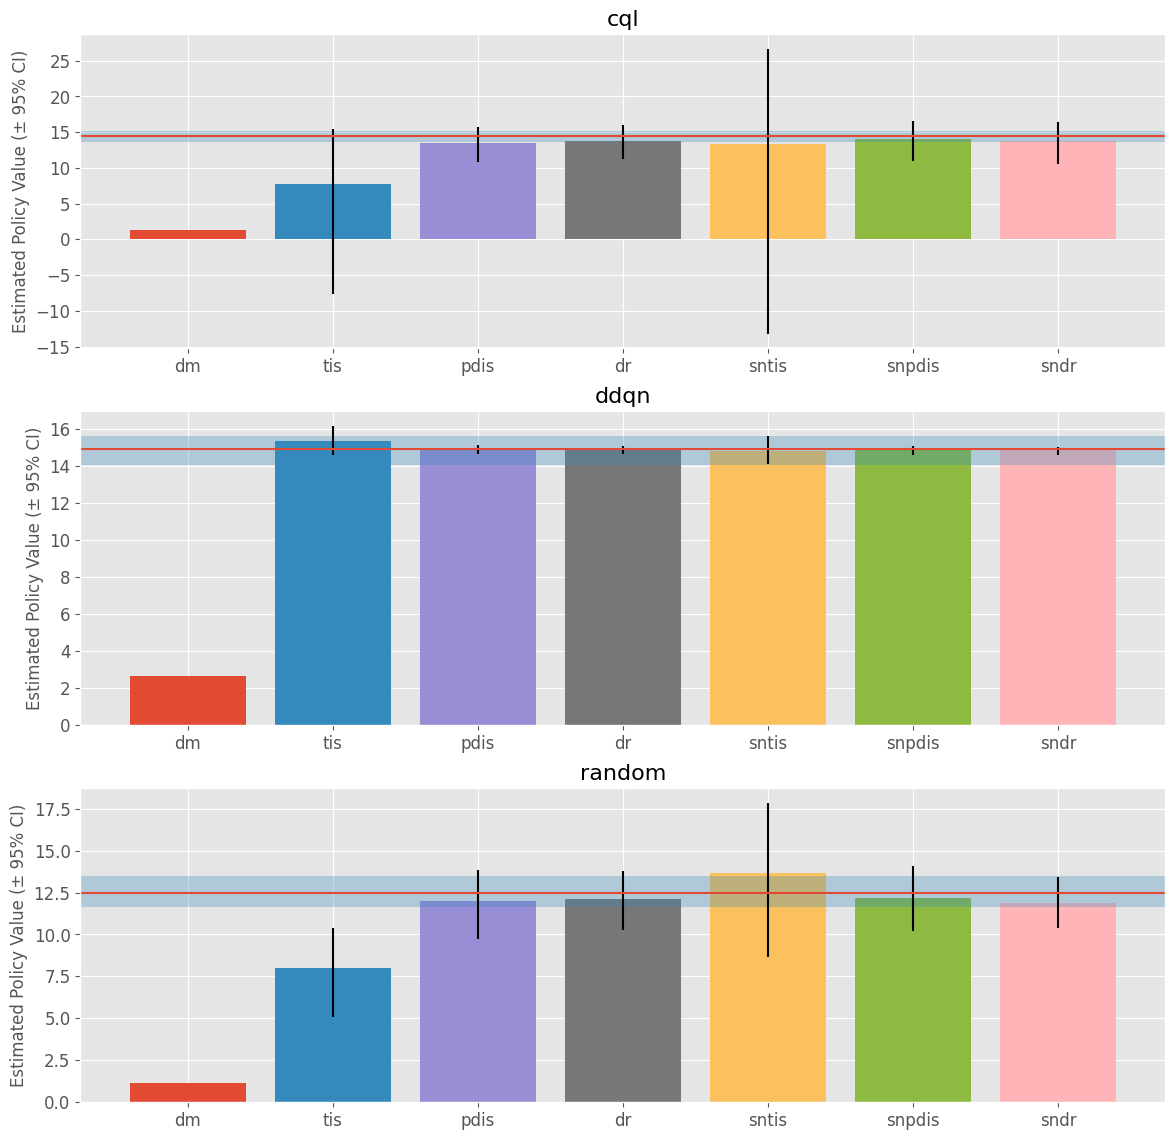

In [43]:
# we can visualize and compare the result
# it seems that DM tends to have a bias though the variance is quite small, 
# while (trajectory-wise) importance sampling estimators have a smaller bias with a larger variance.
# self-normalized estimators also works well
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, sharey=False)

In [44]:
# squared-error (se) measures the estimation accuracy of OPE
eval_metric_ope_df = ope.evaluate_performance_of_ope_estimators(
    input_dict, 
    metric="se",
    return_by_dataframe=True,
)
eval_metric_ope_df

,cql,ddqn,random
dm,174.560607,152.035458,130.987439
tis,42.637874,0.141146,22.528848
pdis,1.344984,0.002508,0.587737
dr,0.723428,0.010608,0.358746
sntis,0.532715,0.015623,0.688413
snpdis,0.474811,0.011263,0.295419
sndr,0.790779,0.015421,0.638238


For more advanced topics in OPE (e.g., cumulative distribution function estimation) and OPS, please refer to [examples/quickstart/rtb/rtb_synthetic_discrete_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_discrete_advanced.ipynb). 

For more advanced OPE estimators (e.g., state(-action) marginal estimators and double reinforcement learning), please refer to [examples/quickstart/rtb/rtb_synthetic_discrete_zoo.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_discrete_zoo.ipynb). 

For the examples in the continuous action space, please refer to [examples/quickstart/rtb/rtb_synthetic_continuous_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rtb/rtb_synthetic_continuous_basic.ipynb).

## Reference

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.